# Midterm

## Options

In [1]:
train_ModelA = False
train_SRGAN = False
continueTraining_SRGAN = False
train_ModelB = False

## Imports

In [2]:
import numpy as np
from tensorflow import keras
import tensorflow as tf
import os
import datetime
import shutil
import re
import time
from tqdm import tqdm

logs_base_dir = "./logs"
shutil.rmtree(logs_base_dir, ignore_errors=True)
os.makedirs(logs_base_dir, exist_ok=True)

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu,True)
    except RuntimeError as e:
        print(e)

%load_ext tensorboard

2023-11-04 02:54:24.660479: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-04 02:54:24.694498: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-04 02:54:25.396000: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-11-04 02:54:26.449780: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-04 0

## Step 1: Training a binary classifier

### Separating the data

In [3]:
label_list = []
cats = [0 for i in range(12500)]
dogs = [1 for i in range(12500)]
label_list.extend(cats)
label_list.extend(dogs)

In [4]:

ds = keras.utils.image_dataset_from_directory(
    directory='data/dogs_cats/train/',
    labels=label_list,
    label_mode='categorical',
    batch_size=64,
    image_size=(128,128),
    seed=0,
    validation_split=0.3,
    subset="both"
)
(train_ds, test_ds) = ds

Found 25000 files belonging to 2 classes.
Using 17500 files for training.
Using 7500 files for validation.


2023-11-04 02:57:38.183503: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-04 02:57:38.183646: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-04 02:57:38.183667: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-04 02:57:39.260834: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-04 02:57:39.260947: I tensorflow/compile

### Preprocess and Augment the data

In [5]:
data_augmentation = keras.Sequential(
    [
        keras.layers.RandomFlip("horizontal"),
        keras.layers.RandomRotation(0.1),
        keras.layers.RandomFlip("vertical"),
        keras.layers.RandomZoom(height_factor=0.1,width_factor=0.1)
    ]
)

### Perform Transfer Learning

### MobileNetV2

In [6]:
base_mobile_model = keras.applications.MobileNetV2(
    weights="imagenet",
    input_shape=(128,128,3),
    include_top=False
)

base_mobile_model.trainable = False

inputs = keras.Input(shape=(128,128,3))
x = data_augmentation(inputs)

scaled_layer = keras.layers.Rescaling(scale=1/255.0)
x = scaled_layer(x)

x = base_mobile_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)
outputs = keras.layers.Dense(2)(x)
mobile_model = keras.Model(inputs, outputs)

mobile_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 128, 128, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 128, 128, 3)       0         
                                                                 
 mobilenetv2_1.00_128 (Func  (None, 4, 4, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 1280)              0     

In [7]:
if train_ModelA:
    keras.backend.clear_session()
    mobile_model.compile(
        optimizer=keras.optimizers.Adam(),
        loss=keras.losses.CategoricalCrossentropy(from_logits=True),
        metrics=[keras.metrics.CategoricalAccuracy()],
    )

    logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
    tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

    epochs = 20
    mobile_model.fit(train_ds, epochs=epochs, callbacks=[tensorboard_callback])

#### Fine Tuning

In [8]:
if train_ModelA:
    keras.backend.clear_session()
    base_mobile_model.trainable = True

    mobile_model.compile(
        optimizer=keras.optimizers.Adam(1e-5),
        loss=keras.losses.CategoricalCrossentropy(from_logits=True),
        metrics=[keras.metrics.CategoricalAccuracy()],
    )

    mobile_model.fit(train_ds, epochs=10, callbacks=[tensorboard_callback])

### Saving Model A

In [9]:
if train_ModelA:
    mobile_model.save_weights("models/modelA.ckpt")
else:
    mobile_model.load_weights("models/modelA.ckpt")

## Step 2: Training SRGAN

In [10]:
def GENBlock(x):
    out = keras.layers.Conv2D(64, (3,3), (1,1), padding='same')(x)
    out = keras.layers.BatchNormalization()(out)
    out = keras.layers.PReLU()(out)
    out = keras.layers.Conv2D(64, (3,3), (1,1), padding='same')(x)
    out = keras.layers.BatchNormalization()(out)
    out = keras.layers.Add()([out, x])
    return out

def DISBlock(x, n):
    out = keras.layers.Conv2D(n, (3,3), (1,1), padding='same')(x)
    out = keras.layers.BatchNormalization()(out)
    out = keras.layers.LeakyReLU(0.2)(out)
    out = keras.layers.Conv2D(n, (3,3), (2,2), padding='same')(x)
    out = keras.layers.BatchNormalization()(out)
    out = keras.layers.LeakyReLU(0.2)(out)
    return out


### Helper Function

In [11]:
import matplotlib.pyplot as plt
from IPython import display

def generate_and_save_images(model, epoch, test_input, gt_output):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 3))

  for i in range(12):
      plt.subplot(4, 3, i+1)
      if i % 3 == 0:
         plt.imshow(tf.cast(tf.clip_by_value(predictions[i // 3, :, :, :], 0, 255), "uint8"))
      elif i % 3 == 1:
         plt.imshow(tf.cast(tf.clip_by_value(test_input[i // 3], 0, 255), "uint8")) 
      else:
         plt.imshow(tf.cast(tf.clip_by_value(gt_output[i // 3], 0, 255), "uint8"))
      
      if i == 0:
         plt.title("Generated")
      elif i == 1:
         plt.title("Resized")
      elif i == 2:
         plt.title("Original")
      plt.axis('off')

  plt.savefig('training_outputs/image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()
  plt.close()

### Generator

In [12]:
inputs = keras.Input(shape=(32,32,3))
scaled_layer = keras.layers.Rescaling(scale=1/255.0, offset=0)

x = scaled_layer(inputs)
x = keras.layers.Conv2D(64, (9,9), (1,1), padding='same')(x)
x = keras.layers.PReLU()(x)
x_skip = x
for i in range(5):
    x = GENBlock(x)
x = keras.layers.Conv2D(64, (3,3), (1,1), padding='same')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Add()([x, x_skip])

x = keras.layers.Conv2D(256, (3,3), (1,1), padding='same')(x)
x = keras.layers.Reshape((x.shape[1]*2, x.shape[2]*2, x.shape[3]//4))(x)
x = keras.layers.PReLU()(x)

x = keras.layers.Conv2D(256, (3,3), (1,1), padding='same')(x)
x = keras.layers.Reshape((x.shape[1]*2, x.shape[2]*2, x.shape[3]//4))(x)
x = keras.layers.PReLU()(x)

outputs = keras.layers.Conv2D(3, (9,9), (1,1), padding='same')(x)

generator_model = keras.Model(inputs, outputs)
generator_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 rescaling_1 (Rescaling)     (None, 32, 32, 3)            0         ['input_3[0][0]']             
                                                                                                  
 conv2d (Conv2D)             (None, 32, 32, 64)           15616     ['rescaling_1[0][0]']         
                                                                                                  
 p_re_lu (PReLU)             (None, 32, 32, 64)           65536     ['conv2d[0][0]']              
                                                                                            

### Discriminator

In [13]:
inputs = keras.Input(shape=(128,128,3))
scaled_layer = keras.layers.Rescaling(scale=1/255.0, offset=0)

x = scaled_layer(inputs)
x = keras.layers.Conv2D(64, (3,3), (1,1), padding='same')(x)
x = keras.layers.LeakyReLU(0.2)(x)
x = keras.layers.Conv2D(64, (3,3), (2,2), padding='same')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.LeakyReLU(0.2)(x)
x = DISBlock(x, 128)
x = DISBlock(x, 256)
x = DISBlock(x, 512)
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(1024)(x)
x = keras.layers.LeakyReLU(0.2)(x)
x = keras.layers.Dense(1)(x)

outputs = keras.activations.sigmoid(x)
outputs = x

discriminator_model = keras.Model(inputs, outputs)
discriminator_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 rescaling_2 (Rescaling)     (None, 128, 128, 3)       0         
                                                                 
 conv2d_15 (Conv2D)          (None, 128, 128, 64)      1792      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 128, 128, 64)      0         
                                                                 
 conv2d_16 (Conv2D)          (None, 64, 64, 64)        36928     
                                                                 
 batch_normalization_11 (Ba  (None, 64, 64, 64)        256       
 tchNormalization)                                               
                                                           

### Training

In [14]:
if train_SRGAN and continueTraining_SRGAN:
    generator_model.load_weights("models/gen_model.ckpt")
    discriminator_model.load_weights("models/dis_model.ckpt")

In [15]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=False)
mse_loss = tf.keras.losses.MeanSquaredError()

vgg_model = keras.applications.VGG19(
    weights="imagenet",
    input_shape=(128,128,3),
    include_top=False
)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

80134624/80134624 [==============================] - 1s 0us/step


In [16]:
@tf.function
def train_step(small_image, big_image):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator_model(small_image, training=True)

        real_output = discriminator_model(big_image, training=True)
        fake_output = discriminator_model(generated_images, training=True)

        disc_loss = discriminator_loss(real_output, fake_output)

        g_loss = generator_loss(fake_output)
        m_loss = mse_loss(big_image, generated_images)
        v_loss = mse_loss(vgg_model(big_image), vgg_model(generated_images))
        gen_loss = g_loss + m_loss + v_loss

        grad_gen = gen_tape.gradient(gen_loss, generator_model.trainable_variables)
        grad_disc = disc_tape.gradient(disc_loss, discriminator_model.trainable_variables)

        generator_optimizer.apply_gradients(zip(grad_gen, generator_model.trainable_variables))
        discriminator_optimizer.apply_gradients(zip(grad_disc, discriminator_model.trainable_variables))

def train(big_dataset, epochs):
    resize_layer = keras.layers.Resizing(32, 32)
    for epoch in tqdm(range(epochs)):
        # start = time.time()
        for big_batch in big_dataset:
            small_batch = resize_layer(big_batch[0])
            train_step(small_batch, big_batch[0])

        iterator_big = iter(big_dataset)
        big_batch = iterator_big.get_next()
        small_batch = resize_layer(big_batch[0])
        generate_and_save_images(generator_model, epoch, small_batch, big_batch[0])
        # print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

In [17]:
if train_SRGAN:
    train(train_ds, 150)

In [18]:
if train_SRGAN:
    generator_model.save_weights("models/gen_model.ckpt")
    discriminator_model.save_weights("models/dis_model.ckpt")
else:
    generator_model.load_weights("models/gen_model.ckpt")
    discriminator_model.load_weights("models/dis_model.ckpt")

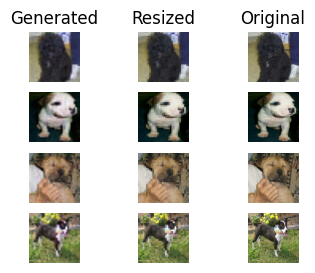

In [20]:
resize_layer = tf.keras.layers.Resizing(32, 32)
iterator = iter(train_ds)
big_dataset = iterator.get_next()
small_dataset = resize_layer(big_dataset[0])

generate_and_save_images(generator_model, 9999, small_dataset, big_dataset[0])

## Train Model B

In [21]:
small_ds = train_ds.map(
    lambda x,y: (generator_model(resize_layer(x), training=False), y)
)
small_ds = small_ds.cache()

In [22]:
base_mobile_modelB = keras.applications.MobileNetV2(
    weights="imagenet",
    input_shape=(128,128,3),
    include_top=False
)

base_mobile_modelB.trainable = False

inputs = keras.Input(shape=(128,128,3))
x = data_augmentation(inputs)

scaled_layer = keras.layers.Rescaling(scale=1/255.0)
x = scaled_layer(x)

x = base_mobile_modelB(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)
outputs = keras.layers.Dense(2)(x)
modelB = keras.Model(inputs, outputs)

modelB.summary()


Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 128, 128, 3)       0         
                                                                 
 rescaling_3 (Rescaling)     (None, 128, 128, 3)       0         
                                                                 
 mobilenetv2_1.00_128 (Func  (None, 4, 4, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d_1  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_1 (Dropout)         (None, 1280)              0   

In [23]:
if train_ModelB:
    keras.backend.clear_session()
    modelB.compile(
        optimizer=keras.optimizers.Adam(),
        loss=keras.losses.CategoricalCrossentropy(from_logits=True),
        metrics=[keras.metrics.CategoricalAccuracy()],
    )

    logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
    tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

    epochs = 20
    modelB.fit(small_ds, epochs=epochs, callbacks=[tensorboard_callback])

In [24]:
if train_ModelB:
    keras.backend.clear_session()
    base_mobile_modelB.trainable = True

    modelB.compile(
        optimizer=keras.optimizers.Adam(1e-5),
        loss=keras.losses.CategoricalCrossentropy(from_logits=True),
        metrics=[keras.metrics.CategoricalAccuracy()],
    )

    modelB.fit(small_ds, epochs=10, callbacks=[tensorboard_callback])

In [25]:
if train_ModelB:
    modelB.save_weights("models/modelB.ckpt")
else:
    modelB.load_weights("models/modelB.ckpt")

## Comparison

In [78]:
true_output = []
predA_output = []
predB_output = []

blah = 0
for batch in test_ds:
    blah = blah + len(batch[0])
    predA = mobile_model(batch[0], training=False)
    predB = modelB(batch[0], training=False)

    true_output.append(batch[1])
    predA_output.append(predA)
    predB_output.append(predB)

In [98]:
import sklearn.metrics
true_output = tf.concat(true_output, 0)
predA_output = tf.concat(predA_output, 0)
predB_output = tf.concat(predB_output, 0)

true_index = tf.argmax(true_output, 1)
predA_index = tf.argmax(predA_output, 1)
predB_index = tf.argmax(predB_output, 1)

In [99]:
A_f1score = sklearn.metrics.f1_score(true_index, predA_index)
B_f1score = sklearn.metrics.f1_score(true_index, predB_index)
print(A_f1score)
print(B_f1score)

0.9692665289256198
0.7059078121618697


In [100]:
A_accuracy = sklearn.metrics.accuracy_score(true_index, predA_index)
B_accuracy = sklearn.metrics.accuracy_score(true_index, predB_index)
print(A_accuracy)
print(B_accuracy)

0.9682666666666667
0.6376


In [101]:
A_confusion = sklearn.metrics.confusion_matrix(true_index, predA_index)
B_confusion = sklearn.metrics.confusion_matrix(true_index, predB_index)
print(A_confusion)
print(B_confusion)

[[3509  205]
 [  33 3753]]
[[1520 2194]
 [ 524 3262]]
